# <font color="purple">**Licenciatura en Tecnologías para la Información en Ciencias**</font>

## <font color="blue">**LTIC-0980: Tópicos Selectos de Ciencia de Datos**</font>

### <font color="blue">**Exploración de patrones en los comentarios de la ENDIREH**</font>

### Angélica Nayeli Rivas Bedolla:    418128734

### Semestre 2021-1

### Miércoles 03 de febrero de 2021

# Introducción

El Instituto Nacional de Estadística y Geografía (INEGI) por medio de La Encuesta Nacional sobre la Dinámica de las Relaciones en los Hogares (ENDIREH), recolecta datos sobre la trascendencia y preeminencia de actos de violencia experimentados con mayor frecuencia por las mujeres mexicanas, contribuyendo al desarrollo de investigaciones y diseño de políticas públicas orientadas a atender y erradicar la violencia contra la mujer. Con esta encuesta se obtienen estimaciones estadísticas que detallan los actos violentos experimentados con mayor frecuencia por las mujeres, en los ámbitos escolar, laboral, familiar y comunitario, los sujetos que ejercen dicha violencia, el espacio físico en donde lo realizan, las relaciones de pareja, las acciones violentas experimentadas a lo largo de estas y la denuncia de estos actos ante las instituciones correspondientes (INEGI, 2016).

# Objetivo

Identificar los tipos de comentarios reportados en la Encuesta Nacional sobre Dinámica de las Relaciones en los Hogares (ENDIREH) 2016, mediante el uso de herramientas de aprendizaje automático, en específico minería de texto. 

# Código fuente

## Librerías

In [1]:
#preprocesamiento
import pandas as pd
import numpy as np
import random
import copy
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

#tokenizar 
import nltk
from nltk.tokenize import RegexpTokenizer 
from nltk.corpus import stopwords

#stemmer
from nltk.stem import SnowballStemmer

#tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

#descomposicion matricial no negativa
from sklearn.decomposition import NMF

#metodo del codo
from sklearn.feature_extraction.text import CountVectorizer 

#clustering
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

#el archivo de funciones auxiliar
from funciones import *

## 1. Conjunto de datos ENDIREH Sección XIX: Comentarios

In [24]:
ruta_parcial = "conjunto_de_datos_tb_sec_xix_endireh_2016/conjunto_de_datos/conjunto_de_datos_tb_sec_xix_endireh_2016.csv"
#ruta_parcial = "../conjunto_de_datos_tb_sec_xix_endireh_2016/conjunto_de_datos/conjunto_de_datos_tb_sec_xix_endireh_2016.csv"

endireh = pd.read_csv(ruta_parcial, na_values=['\r'])

In [3]:
endireh.head()

,ID_VIV,ID_MUJ,UPM,REN_M_ELE,VIV_SEL,PROG,HOGAR,DOMINIO,CVE_ENT,NOM_ENT,...,P19_1,P19_1e,P19_2,P19_2e,O_ACT_VIO,FAC_VIV,FAC_MUJ,ESTRATO,UPM_DIS,EST_DIS
0,100090.04,0100090.04.01.02\r,100090,2,4,78,1,U\r,1,Aguascalientes\r,...,0.0,NaN,1,NaN,NaN,72,72,2,26,10
1,100097.01,0100097.01.01.02\r,100097,2,1,18,1,U\r,1,Aguascalientes\r,...,0.0,NaN,1,NaN,NaN,82,82,2,28,10
2,100097.05,0100097.05.01.01\r,100097,1,5,121,1,U\r,1,Aguascalientes\r,...,0.0,NaN,1,NaN,NaN,82,82,2,28,10
3,100097.03,0100097.03.01.02\r,100097,2,3,130,1,U\r,1,Aguascalientes\r,...,0.0,NaN,1,NaN,NaN,82,82,2,28,10
4,100101.03,0100101.03.01.01\r,100101,1,3,33,1,U\r,1,Aguascalientes\r,...,0.0,NaN,1,NaN,NaN,94,94,3,29,20


#### Columnas en el conjunto de datos

In [4]:
endireh.columns

Index(['ID_VIV', 'ID_MUJ', 'UPM', 'REN_M_ELE', 'VIV_SEL', 'PROG', 'HOGAR',
       'DOMINIO', 'CVE_ENT', 'NOM_ENT', 'CVE_MUN', 'NOM_MUN', 'COD_RES',
       'COD_RES_MU', 'T_INSTRUM', 'P19_1', 'P19_1e', 'P19_2', 'P19_2e',
       'O_ACT_VIO', 'FAC_VIV', 'FAC_MUJ', 'ESTRATO', 'UPM_DIS', 'EST_DIS'],
      dtype='object')

El archivo CSV tiene 25 atributos que representan: ID_VIV (identificador de vivienda), ID_MUJ (identificador de mujer), HOGAR (número de hogar de la mujer), DOMINIO (tipo de vivienda), CVE_ENT (clave de entidad federativa), NOM_ENT (nombre de entidad federativa), CVE_MUN (clave de municipio), NOM_MUN (nombre de municipio), COD_RES_MU (si se completó la entrevista), COD_RES (por quién se completó la entrevista), T_INSTRUM (tipo de entrevista hecha), P9_1 (comentarios adicionales), P9_1e (el comentario), P9_2 (cómo se sintió la entrevistada), P9_2e (un sentir diferente al especificado en respuestas), y, O_ACT_VIO (actos violentos diferentes a los especificados en el cuestionario). Entre otras columnas que no tienen explicación de qué información representan. 

#### Tamaño del conjunto de datos

In [5]:
endireh.shape

(111256, 25)

#### Cantidad de registros sin comentarios.

In [6]:
endireh[['P19_1e']].isnull().sum()

P19_1e    108329
dtype: int64

Solo 2,927 de las entrevistadas dijeron un comentario sobre la entrevista.

#### Eliminar los registros que no tienen comentarios

In [25]:
endireh_c = copy.copy(endireh)

In [26]:
endireh_c.dropna(subset=['P19_1e'], inplace=True) #borro los registros que tienen NaN en lugar de comentarios
endireh_c.reset_index(drop=True, inplace=True) #reajustar el índice

#### Cuantos comentarios tienen una categoría de violencia (O_ACT_VIO)

In [9]:
endireh_c['O_ACT_VIO'].value_counts()

5.0    18
4.0    11
2.0     6
6.0     3
3.0     3
1.0     3
Name: O_ACT_VIO, dtype: int64

#### La cantidad de comentarios en cada sentir sobre la entrevista (P19_2)

In [10]:
endireh_c['P19_2'].value_counts()

1    2360
2     344
3     114
4     109
Name: P19_2, dtype: int64

## 2. Preprocesamiento de datos

#### Obtener la columna que contiene los comentarios

In [27]:
comentarios = endireh_c['P19_1e']

#### Eliminar signos de puntuación y hacer stem

Dado que no hay forma de lematizar en español con la librería NLTK y no es bueno el _stemmer_ para español porque se pierde información, se harán don implementos:
 1. solo  eliminar los signos de puntuación.
 2. eliminar signos de puntuación y _stemmer_.

Al pasar un texto a _tokenizer_ va a devolver tokens SIN signos de puntuación. Sólo palabras.

In [13]:
tokenizador = RegexpTokenizer(r'\w+')
stemmer = SnowballStemmer('spanish')

In [43]:
def Tokenizer(texto):
    tokens = tokenizador.tokenize(texto.lower())
    return ' '.join(tokens)

In [44]:
def Stemmer(texto):
    tokens = tokenizador.tokenize(texto.lower())
    letras_stem = []
    for t in tokens:
        letras_stem.append((stemmer.stem(t)))

    return ' '.join(letras_stem)

## 3. Encontrar las $k$ palabras principales de los $n$ temas.

Justificación aquí

In [22]:
def factorizacion(preprocessor, texts, n_components, k, semilla=42):
    """
    Recibe:
        preprocessor: funcion para preprocesar textos
        texts: estructura de datos (pansas dataframe, lista) con los textos
        n_components: componentes para realizar la factorizacion matricial NMF, cantidad de temas
        k: cantidad de terminos a mostrar
        semilla: para el creador de numeros aleatorio de NMF
    Devuelve:
        topics: matriz con n columnas y k filas (n=temas, k=palabras).
    """
    ##########
    ##TF-IDF##
    ##########
    #crear el vectorizador TF-IDF
    vectorizer = TfidfVectorizer(stop_words=stopwords.words('spanish'), 
                                 lowercase=True, 
                                 strip_accents='ascii', 
                                 preprocessor=preprocessor)
    
    #vectorizar textos
    comentarios = vectorizer.fit_transform(texts)
    
    #Obtengo el diccionario que transforma de index a término usando un comprehension dictionary
    id_2_vocab = {value:key for (key,value) in vectorizer.vocabulary_.items()}
    
    #######
    ##NMF##
    #######
    #crear el modelo NMF
    model = NMF(n_components=n_components, init='random', random_state=semilla)
    #obtengo las matrices caracteristicas 
    W = model.fit_transform(comentarios)
    H = model.components_

    ###################################
    ##Obtener k palabras de cada tema##
    ###################################
    #Las matrices obtenidas con _sklearn_ tienen los valores invertidos
    #W es H y viceversa, y estan en transpuesta.
    #para poder ver una matriz (temas, palabras) se obtiene la transpuesta de la verdadera W, o sea, H original.
    topics = defaultdict(lambda : [])
    for i in range(H.shape[0]): 
        topics[i] = [id_2_vocab[t] for t in np.argsort(H[i])[-k:]]

    return topics

## 4. Ejecuciones

Se propusieron 3 números de componentes para la factorización no negativa: con 2 componentes, con 4 y con método del codo. Para 2 como número de componentes es porque en la columna O\_ACT\_VIO existen 2 tipos principales de comentarios: de violencia y no violencia, aunque no están representados proporciones similares, veremos si puede diferenciarlos. Para 4 como número de componentes es porque la columnas P19\_2 tiene 4 categorías, tampoco están representados en la misma cantidad pero al menos no es tan abrupto como en O\_ACT\_VIO. Con el método del codo se elige de acuerdo a la inercia en el método de agrupación de K-Medias, se calcula el codo para $k\in[1, ..., 15]$. Esto junto a los tipos de preprocesamiento da como resultado un total de 6 experimentos.

### 4.1 Con $n$=2

Como visto en la columna _O\_ACT\_VIO_, puede haber 2 tipos principales de comentarios: de violencia o no violencia.
Por ello, se hace una descomposición de 2 factores, para saber si se puede dintinguir entre estos dos tipos.

#### Con _tokens_.

In [67]:
temas = factorizacion(preprocessor=Tokenizer, texts=comentarios, n_components=2, k=5, semilla=5)
pd.DataFrame(temas)

,0,1
0,tiempo,sentí
1,comenta,parece
2,entrevistada,parecio
3,preguntas,preguntas
4,encuesta,muchas


#### Con _tokens_ y _stemmer_.

In [14]:
temas = factorizacion(preprocessor=Stemmer, texts=comentarios, n_components=2, k=5, semilla=5)
pd.DataFrame(temas)

,0,1
0,tiemp,senti
1,coment,parec
2,entrevist,pareci
3,pregunt,pregunt
4,encuest,much


Lo que interpreto en cada columna es:

 0. sobre qué piensan de la encuesta en sí.
 1. cómo se sintieron durante la encuesta.

 Da buenos resultados ya que podemos obtener dos cosas de valor sobre la encuesta, el que tal recibió el público la encuesta y la satisfacción de este. Pero no lo que buscábamos que era clasificar por tipo de mensaje, violento o no.

### 4.2 Con $n$=4

Como visto en la columna _P19\_2_, tiene 4 tipos principales de comentarios: bien, mal, indiferente y otro.
Por ello, se hace una descomposición de 4 factores, para saber si se puede dintinguir entre estos cuatro tipos.

#### Con _tokens_.

In [77]:
temas = factorizacion(preprocessor=Tokenizer, texts=comentarios, n_components=4, k=5, semilla=66)
pd.DataFrame(temas)

,0,1,2,3
0,vida,senti,preguntas,aburrida
1,pareja,sintio,buenas,tiempo
2,hijos,tranquila,gracias,extensa
3,problemas,parece,repetitivas,tediosa
4,violencia,parecio,largo,preguntan


#### Con _tokens_ y _stemmer_.

In [40]:
temas = factorizacion(preprocessor=Stemmer, texts=comentarios, n_components=4, k=5, semilla=66)
pd.DataFrame(temas)

,0,1,2,3
0,pregunt,vid,senti,aburr
1,buen,parej,parec,pregunt
2,repetit,hijs,tranquila,tiemp
3,larg,problem,pues,extens
4,graci,violenci,pareci,tedios


Lo que interpreto en cada columna es:

 0. vida en pareja, hijos, violencia y problemas.
 1. cómo se sintieron durante la encuesta.
 2. sobre qué piensan de la encuesta en sí, neutral.
 3. sobre qué piensan de la encuesta en sí, en negativo.


Se supone que de las encuestadas que dieron un comentario, un 80\% se categorizó como sentirse bien, pero no salió alguna categoría positiva, solo negativo y mezcla entre positivo y negativo, lo cual hace que sea una repetición innecesaria sobre el mismo tipo de comentarios. Aparte apareció una categoría que representa violencia, a la mayor cantidad de comentarios se ven representados esos 44 comentarios sobre violencia.

### 4.3 Elección de la $n$ con método del codo

Los algoritmo usados en esta sección perteneces al archivo _funciones.py_

#### Con _tokens_

Vectorizo las palabras

In [17]:
vectorizador = CountVectorizer(stop_words=stopwords.words('spanish'), preprocessor=Tokenizer) 
M = vectorizador.fit_transform(comentarios)

Con la función que calcula las inercias de las agrupaciones, obtengo los valores del codo y los grafico.

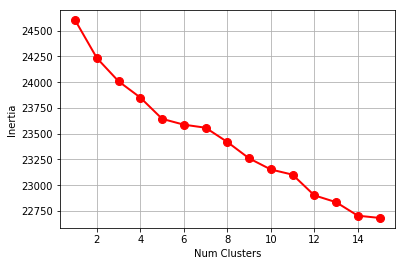

In [18]:
codo = select_clusters(M, 15)
plot_results_codo(codo, "ro-")

Donde aparece un primer codo es en $n$ = 3

In [71]:
temas = factorizacion(preprocessor=Tokenizer, texts=comentarios, n_components=3, k=5, semilla=42)
pd.DataFrame(temas)

,0,1,2
0,aburrida,tranquila,hijos
1,pregunta,gracias,problemas
2,demasiado,sintio,mujer
3,extensa,haciendo,esposo
4,tediosa,pues,violencia


Lo que interpreto en cada columna es:

 0. sobre qué piensan de la encuesta en sí.
 1. cómo se sintieron durante la encuesta.
 2. sobre algo no relacionado a la encuesta.

Esta agrupación tiene buen rendimiento porque tiene de las 3 cosas que queríamos: violencia, pensamiento de la encuesta y su sentir sobre la encuesta, y sin ambigüedad entre la diferencia de las categorías.

#### Con _tokens_ y _stemmer_.

Vectorizo las palabras

In [28]:
vectorizador = CountVectorizer(stop_words=stopwords.words('spanish'), preprocessor=Stemmer) 
M = vectorizador.fit_transform(comentarios)

Con la función que calcula las inercias de las agrupaciones, obtengo los valores del codo y los grafico.

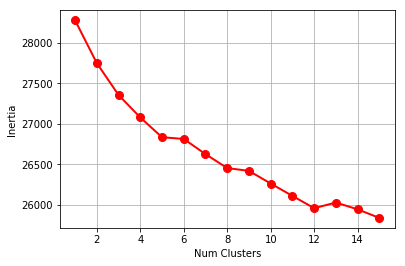

In [29]:
codo = select_clusters(M, 15)
plot_results_codo(codo, "ro-")

Donde está un codo más marcado es en $n$ = 5

In [37]:
temas = factorizacion(preprocessor=Stemmer, texts=comentarios, n_components=5, k=5, semilla=2)
pd.DataFrame(temas)

,0,1,2,3,4
0,hij,buen,gobiern,aburr,pregunt
1,parej,sinti,trabaj,pregunt,tranquil
2,espos,repit,hombr,demasi,senti
3,problem,repetit,tip,extens,tip
4,violenci,pregunt,violenci,tedios,bien


Lo que interpreto en cada columna es:

 0. palabras relacionadas a familia y violencia.
 1. sobre qué piensan de la encuesta en sí, en positivo.
 3. La relación entre gobierno-trabajo-hombres-violencia.
 3. sobre qué piensan de la encuesta en sí, mayoría negativo.
 4. cómo se sintieron durante la encuesta.


Tiene la misma repetición innecesaria de categorías que cuando eran 4 componentes pero esta vez salió una columna interesante. Gobierno, trabajo, hombre y violencia en los primeros puestos. Me atreví a llamarle Patriarcado porque esto es lo que representa. 

# 6. Conclusiones

Los comentarios salieron en su mayoría negativos, no porque el pensamiento en general de la encuesta sea negativo, sino que todas las personas que dijeron comentarios lo hicieron para expresar esta inconformidad.

Al tener más componentes nos arriesgamos a que varios de estos tengan significados similares, como la percepción de los comentarios negativos y neutros, pero también ayuda a obtener categorías que cuando hay menos componentes son asignados a categorías con mayor impacto. Así pudimos ver el tipo de comentarios patriarcales que ahonda en el tipo de violencia sistemática que están comentando las encuestadas.

La categorización de 3 componentes es la mejor categorización para estos comentarios, ya que resuelve el problema de tener demasiadas componentes donde varios de sus componentes tiene significados similares o de diferencia dudosa, pero tiene las suficientes para obtener buena información.
